# Word2vec model
This model uses a pretrained word2vec to vectorize the paragraphs, with weights based on a TF-IDF vectorizer. This is evaluated with a simple linear SVM.

A pretrained word2vec can be found on [this github repo](https://github.com/3Top/word2vec-api).

In [1]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
from gensim.models import Word2Vec
from gensim.test.utils import datapath
from gensim.models import KeyedVectors
from sklearn.metrics import confusion_matrix
import itertools

In [2]:
df = pd.read_csv("../../data/ad_hominem/ad_hominems_cleaned_Murilo.csv", sep=",", index_col=0, header=0, names=["body", "isAdHominem"])

In [405]:
from sklearn.model_selection import train_test_split

train, test = train_test_split( df, test_size=0.3, random_state=1)

print("In total, the train contains", sum(train["isAdHominem"] == True), "ad hominems")
print("In total, the test contains", sum(test["isAdHominem"] == True), "ad hominems")

In total, the train contains 1731 ad hominems
In total, the test contains 766 ad hominems


In [406]:
features=300

In [407]:
print("Starting TF-IDF vectorizer")
from sklearn.feature_extraction.text import TfidfVectorizer
v = TfidfVectorizer( ngram_range = (1, 1), max_features=features, stop_words="english")
v.fit(train['body'].values.astype('U'))
x_train = v.transform(train['body'].values.astype('U'))
x_test = v.transform(test['body'].values.astype('U'))

Starting TF-IDF vectorizer


In [436]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap, vmin=0)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
        
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [7]:
df.head()

,body,isAdHominem
0,What makes corporations different in this case...,0
1,I'm sorry if your smugness gets in the way. Li...,1
2,"Basically to believe a patriarchy exists, you ...",0
3,The punishment for heresy was being burned at ...,0
4,No it doesn't. Sex is defined by DNA. DNA cann...,0


In [8]:
print("importing word2vec")
wv_from_bin = KeyedVectors.load_word2vec_format(datapath("/Users/pieterdelobelle/Downloads/GoogleNews-vectors-negative300.bin.gz"), binary=True)  # C binary format
print("imported word2vec")

importing word2vec
imported word2vec


In [408]:
wordvecs = np.zeros( (len(v.vocabulary_), len(wv_from_bin["test"])))
for i,k in enumerate(v.vocabulary_):
    if k in wv_from_bin:
        wordvecs[i] = wv_from_bin[k]

In [48]:
def combineData( dataset ):
    train_w2v = np.zeros( (dataset.shape[0], len(v.vocabulary_), len(wv_from_bin["test"])))
    for i in range(0,dataset.shape[0]):
        if (100* i / dataset.shape[0] % 10 == 0):
            print("{} of {} ({} %)\r".format(i, dataset.shape[0], 100* i / dataset.shape[0]))
    
        train_w2v[i] = np.multiply(wordvecs.T,dataset[i,:].toarray().flatten()).T
    return train_w2v

In [409]:
test_x = combineData(x_train)

0 of 20505 (0.0 %)
4101 of 20505 (20.0 %)
8202 of 20505 (40.0 %)
12303 of 20505 (60.0 %)
16404 of 20505 (80.0 %)


In [410]:
test_y = combineData(x_test)

0 of 8789 (0.0 %)


In [474]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import LSTM
from keras.layers import Conv1D, PReLU, Flatten
from keras.layers import Dense, Activation, Dropout
from keras.callbacks import ModelCheckpoint
from keras.utils import np_utils
import tensorflow as tf

model = Sequential()

model.add(Dense(32, input_shape=(features, len(wv_from_bin["test"]))))
#model.add(LSTM(10, return_sequences=True, input_shape=(features, len(wv_from_bin["test"]))))
#model.add(LSTM(4))
#model.add(Dropout(0.1))
model.add(Flatten())
model.add(Dense(1))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [381]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_44 (Dense)             (None, 200, 32)           9632      
_________________________________________________________________
flatten_1 (Flatten)          (None, 6400)              0         
_________________________________________________________________
dense_45 (Dense)             (None, 1)                 6401      
Total params: 16,033
Trainable params: 16,033
Non-trainable params: 0
_________________________________________________________________


In [382]:
batch_size = 500
epochs = 4

## Fix imbalance

In [412]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(train["isAdHominem"]),
                                                 train["isAdHominem"])

In [413]:
class_weights

array([0.55, 5.92])

In [414]:
history = model.fit(test_x, train["isAdHominem"],
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.1,
                    class_weight=class_weights)

Train on 18454 samples, validate on 2051 samples
Epoch 1/4
18454/18454 [==============================] - 66s 4ms/step - loss: 0.3279 - acc: 0.9158 - val_loss: 0.2807 - val_acc: 0.9132
Epoch 2/4
18454/18454 [==============================] - 53s 3ms/step - loss: 0.2658 - acc: 0.9158 - val_loss: 0.2756 - val_acc: 0.9132
Epoch 3/4
18454/18454 [==============================] - 50s 3ms/step - loss: 0.2558 - acc: 0.9160 - val_loss: 0.2680 - val_acc: 0.9132
Epoch 4/4
18454/18454 [==============================] - 52s 3ms/step - loss: 0.2534 - acc: 0.9173 - val_loss: 0.2801 - val_acc: 0.9152


In [415]:
predicted = model.predict(test_y)

In [240]:
#predicted = model.predict(test_x)

In [404]:
model.save_weights("model02.h5")

Confusion matrix, without normalization
[[4932 3091]
 [ 208  558]]
Normalized confusion matrix
[[0.61 0.39]
 [0.27 0.73]]


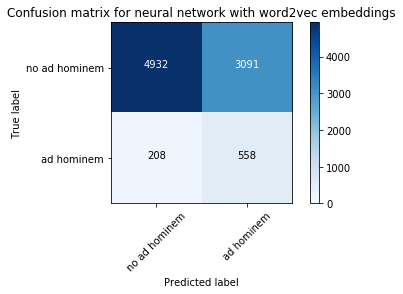

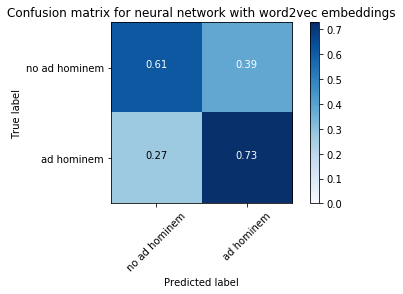

In [438]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(test["isAdHominem"], predicted > 0.09)

np.set_printoptions(precision=2)

title="Confusion matrix for neural network with word2vec embeddings"

# Plot normalized confusion matrix
fig = plt.figure()
plot_confusion_matrix(cnf_matrix, classes=["no ad hominem", "ad hominem"],normalize=False, 
                      title=title)

#print('plots exported.png')
#fig.savefig("model02_not_normalized.png")

# Plot non-normalized confusion matrix
fig = plt.figure()
plot_confusion_matrix(cnf_matrix, classes=["no ad hominem", "ad hominem"],normalize=True, 
                      title=title)
#fig.savefig("model02_normalized.png")

## Calculate ROC area onder curve in function of threshold

In [472]:
from sklearn.metrics import roc_auc_score
inp = np.arange(0,0.5,0.005)
results = []
for i in inp:
    results.append(roc_auc_score(test["isAdHominem"], predicted > i))

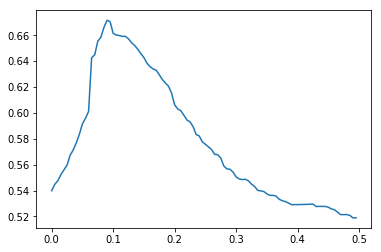

In [473]:
plt.plot(inp, results)